# Skeleton Matching using Skeleton Context

## Introduction
This is a demo of our skeleton matching using Skeleton Context described in publications below. If you use this code or part of it for your research please respectfully cite these publications:

[1] Kamani, M.M., Farhat, F., Wistar, S. and Wang, J.Z., 2017. Skeleton Matching with Applications in Severe Weather Detection, Applied Soft Computing. [Link1](http://www.sciencedirect.com/science/article/pii/S1568494617303009) [Link2](https://pdfs.semanticscholar.org/a90c/ffa078ed566a1cb046ec68fd7195f01c7a76.pdf)

[2] Kamani, M.M., Farhat, F., Wistar, S. and Wang, J.Z., 2016, December. Shape matching using skeleton context for automated bow echo detection. In Big Data (Big Data), 2016 IEEE International Conference on (pp. 901-908). IEEE. [Link1](http://ieeexplore.ieee.org/abstract/document/7840685/) [Link2](https://pdfs.semanticscholar.org/ae62/d5802980859ead8288f6ff436754253882d6.pdf)

som part of the codes are transfered from Matlab version of shape context developed by UC Berkeley's vision group [here](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/code/sc_demo/)

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import sys  
sys.path.insert(0, '/content/drive/MyDrive/YangLab/UnityTool/Hand-Interfaces/Blender Files/Skeleton Matching')

In [31]:
from __future__ import division
import os
import skeletonContext as sc
from skeleton2Graph import skeleton2Graph, mat2gray
from skimage import io
from matplotlib import pyplot as plt
import numpy as np
from IPython import display

First we load images of the skeletons to be matched. Then we would start from one end and traverse to the other end of the skeleton in order to calulate thet tangent estimate of it.

In [32]:
s1 = mat2gray(io.imread(os.path.join(os.getcwd(), 'drive/MyDrive/YangLab/UnityTool/Hand-Interfaces/Blender Files/Skeleton Matching/img/s1.png'),as_gray=True)).astype('float64')
s2 = mat2gray(io.imread(os.path.join(os.getcwd(), 'drive/MyDrive/YangLab/UnityTool/Hand-Interfaces/Blender Files/Skeleton Matching/img/s2.png'),as_gray=True)).astype('float64')
_, edgeList1, _, _, _, _, _, _ = skeleton2Graph(s1,s1)
_, edgeList2, _, _, _, _, _, _ = skeleton2Graph(s2,s2)
s1Tangent, s1PointsList = sc.skeletonTangentEstimate(edgeList1)
s2Tangent, s2PointsList = sc.skeletonTangentEstimate(edgeList2)

Setting initial parameters for matching.

In [33]:
'''Initial Paramters'''
displayFlag=1
affineStartFlag=1
polarityFlag=0
nsamp= 100
costDum=0.15
numDumRate=0.6
thetaWeight=0.2
nbins_theta=12
nbins_r=5
r_inner=1/8
r_outer=2
tan_eps=1.0
numIter=20
betaInit=1
r=1
w=4
sf=2.5
neighborWeight = 0.6
skeletonMatchCost  = np.zeros(numIter)
affineCost         = np.zeros(numIter)
bendingEnergy      = np.zeros(numIter)
matchRatio         = np.zeros(numIter)
dimSize = np.max(np.array([s1.shape,s2.shape]),0)

In [34]:
t2 = sc.bdry_extract(s2,s2PointsList)
if len(s2PointsList) >= nsamp:
    s2PointsList, t2,s2Tangent = sc.get_samples(s2PointsList,t2,s2Tangent, nsamp)
else:
    raise ValueError('Skeleton 2 does not have enough samples')
t1 = sc.bdry_extract(s1,s1PointsList)
if len(s1PointsList) >= nsamp:
    s1PointsList, t1,s1Tangent = sc.get_samples(s1PointsList,t1,s1Tangent, nsamp)
else:
    raise ValueError('Skeleton 1 does not have enough samples')

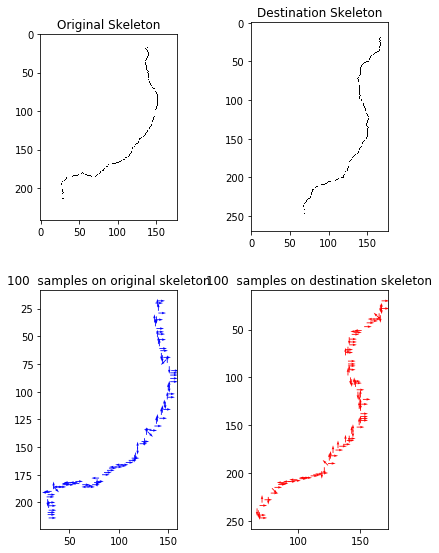

In [35]:
if displayFlag:
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(6,8))
    ax1.imshow(s1,cmap='gray_r')
    ax1.set_title('Original Skeleton')
    ax2.imshow(s2,cmap='gray_r')
    ax2.set_title('Destination Skeleton')
    ax3.quiver(s1PointsList[:,1],s1PointsList[:,0],np.sin(t1),np.cos(t1),color='b')
    ax3.invert_yaxis()
    ax3.set_title(str(len(s1PointsList)) + '  samples on original skeleton')
    ax4.quiver(s2PointsList[:,1],s2PointsList[:,0],np.sin(t2),np.cos(t2),color='r')
    ax4.invert_yaxis()
    ax4.set_title(str(len(s2PointsList)) +'  samples on destination skeleton')
    plt.tight_layout()
    plt.show()   

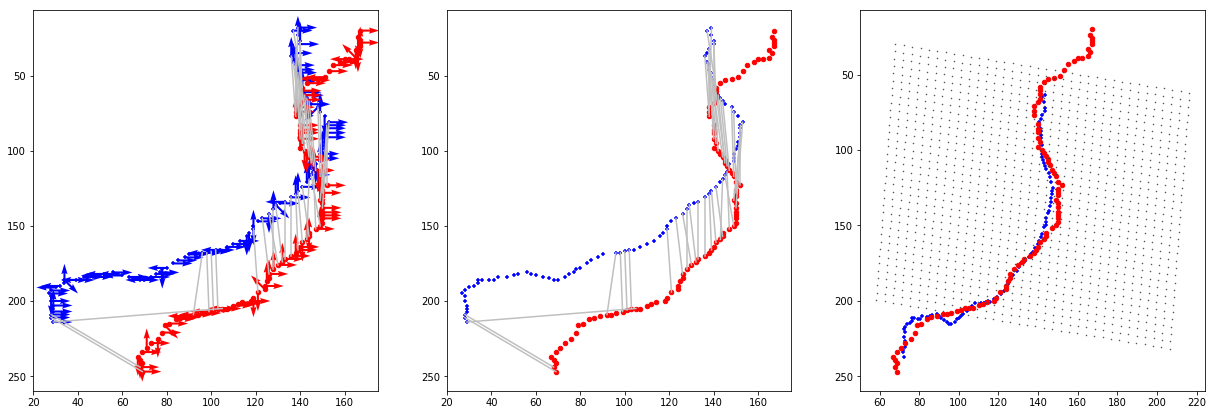

          Iteration       Bending Energy         Affine Cost       Matching Cost      Matching Ratio
                   1    7.6210822114e-07      0.555538975263      0.180216382896                0.42


In [37]:
'''Compute Matching points'''
X = np.copy(s1PointsList)
Y = np.copy(s2PointsList)
Xk = X
tk = t1

numDumPoints = int(numDumRate * nsamp)
outVec1 = np.zeros(nsamp)
outVec2 = np.zeros(nsamp)
neighborMap = np.tile(np.arange(1,nsamp+1),(nsamp,1))
neighborCost = np.zeros((nsamp,nsamp))
if displayFlag:
    f, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(21,7))
    ax1.invert_yaxis()
    ax2.invert_yaxis()
    ax3.invert_yaxis()
    x = np.linspace(0, dimSize[1], 36)
    y = np.linspace(0, dimSize[0],36)
    xv, yv = np.meshgrid(x, y)
    xv = np.reshape(xv.T,-1)
    yv = np.reshape(yv.T,-1)
    M = len(xv)
    printList = ['Bending Energy','Affine Cost', 'Matching Cost', 'Matching Ratio']
    row_format ="{:>20}" * (len(printList) + 1)
    print row_format.format("Iteration ", *printList)
for k in range(numIter):
    pointHistogram1, meanDistance1 = sc.skeletonContext(Xk.T,np.zeros(nsamp),nbins_theta,nbins_r,r_inner,r_outer,outVec1)
    pointHistogram2, meanDistance2 = sc.skeletonContext(Y.T,np.zeros(nsamp),nbins_theta,nbins_r,r_inner,r_outer,outVec2)
    
    if affineStartFlag:
        if k == 0:
            lambda_o = 1000;
        else:
            lambda_o = betaInit * pow(r,k-1)
    else:
        lambda_o = betaInit * pow(r,k)
    beta_k=(pow(meanDistance2,2)) * lambda_o
    
    costMatShape = sc.HistCost(pointHistogram1,pointHistogram2)
    thetaDiff = np.tile(tk,[nsamp,1]).T - np.tile(t2,[nsamp,1])
    
    if polarityFlag:
        costMatTheta = 0.5 * (1 - np.cos(thetaDiff))
    else:
        costMatTheta = 0.5 * (1 - np.cos(2 * thetaDiff))
    
    costMat = (1 - thetaWeight) * costMatShape + thetaWeight * costMatTheta
    costMat += neighborCost
    
    # Calculate Skeleton Context cost
    costMatTemp = costMat - neighborCost
    a1 = np.min(costMatTemp,0)
    a2 = np.min(costMatTemp,1)
    skeletonMatchCost[k] = max(np.mean(a1),np.mean(a2))
    
    numMatchPoints = nsamp + numDumPoints
    costMatDum = costDum * np.ones((numMatchPoints,numMatchPoints))
    costMatDum[0:nsamp,0:nsamp] = costMat
    matchedVec, _ = sc.hungarian(costMatDum)
    matchedVec2 = np.argsort(matchedVec)
    
    '''Neighboring Effect'''
    s1PointsMatchedInd = matchedVec2[:nsamp] <= nsamp
    s1PointsMatched = np.argwhere(s1PointsMatchedInd)
    matchDifference = s1PointsMatched - matchedVec2[s1PointsMatched]
    matchDifferenceMean = np.mean(matchDifference)
    matchDifferenceStd = np.std(matchDifference)
    outlierInd = (matchDifference >=  (matchDifferenceMean + 2.5 * matchDifferenceStd)) | (matchDifference <=  (matchDifferenceMean - 2.5 * matchDifferenceStd))
    matchRatio[k] = len(s1PointsMatched) / nsamp
    if matchRatio[k] <= 0.65:
        if (k != 0 & outlierInd.any() ):
            outlierMatchS2Points = s1PointsMatched[outlierInd]
            outlierMatchS1Points = matchedVec2[outlierMatchS2Points]
            matchedVec2[outlierMatchS2Points] = numMatchPoints
            matchedVec[outlierMatchS1Points] = numMatchPoints
            
            s1PointsMatchedInd = matchedVec2[:nsamp] <= nsamp
            s1PointsMatched = np.argwhere(s1PointsMatchedInd)
            matchDifference = s1PointsMatched - matchedVec2[s1PointsMatched]
            matchDifferenceMean = np.mean(matchDifference)
            matchDifferenceStd = np.std(matchDifference)
        
        neighborMean = neighborMap.T - matchDifferenceMean
        neighborCost = neighborWeight * (1 - np.exp(- (neighborMap - neighborMean)**2 / (2 * 10**2)))
    else:
        neighborCost = np.zeros((nsamp,nsamp))
    
    outVec1 = matchedVec2[:nsamp] > nsamp
    outVec2 = matchedVec[:nsamp] > nsamp
    
    X2 = np.nan * np.ones((numMatchPoints,2))
    X2[:nsamp,:] = np.copy(Xk)
    X2 = X2[matchedVec - 1,:]
    X2b = np.nan * np.ones((numMatchPoints,2))
    X2b[:nsamp,:] = X
    X2b = X2b[matchedVec - 1,:]
    Y2 = np.nan * np.ones((numMatchPoints,2))
    Y2[:nsamp,:] = np.copy(Y)
    
    indGood = np.where(~np.isnan(X2b[:nsamp,0]))[0]
    numGood = len(indGood)
    X3b = X2b[indGood,:]
    Y3  = Y2[indGood,:]
    
    if displayFlag:
        ax1.clear()
        ax1.scatter(X2[:,1],X2[:,0],c='b', marker='+',s=20)
        ax1.scatter(Y2[:,1],Y2[:,0],c='r',marker='o',s=20)
        ax1.plot(np.stack((X2[:,1],Y2[:,1]),axis=1).T,np.stack((X2[:,0],Y2[:,0]),axis=1).T,c='0.75')
        ax1.quiver(Xk[:,1],Xk[:,0],np.sin(tk),np.cos(tk),color='b')
        ax1.quiver(Y[:,1],Y[:,0],np.sin(t2),np.cos(t2),color='r')
        ax1.invert_yaxis()
        display.clear_output(wait=True)
        display.display(plt.gcf())
        ax2.clear()
        ax2.scatter(X[:,1],X[:,0],c='b', marker='+',s=20)
        ax2.scatter(Y[:,1],Y[:,0],c='r',marker='o',s=20)
        ax2.plot(np.stack((X2b[:,1],Y2[:,1]),axis=1).T,np.stack((X2b[:,0],Y2[:,0]),axis=1).T,c='0.75')
        ax2.invert_yaxis()
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
        
    
    # Calculate bending energy
    cx,cy,E,_ = sc.bookstien(X3b , Y3, beta_k)
    bendingEnergy[k] = E
    # Calculating affine cost
    A = np.vstack((cx[numGood + 1:numGood + 3], cy[numGood + 1:numGood + 3]))
    _,s,_ = np.linalg.svd(A)
    affineCost[k] = np.log(s[0]/s[1])
    
    # warp coordinates
    fx_aff = np.dot(cx[numGood:numGood + 3].T,np.vstack((np.ones((1,nsamp)),X.T)))
    d2 = sc.dist2(X3b, X)
    U = d2 * np.log(d2 + np.finfo(float).eps)
    fx_wrp = np.dot(cx[:numGood].T,U)
    fx = fx_aff + fx_wrp
    fy_aff = np.dot(cy[numGood:numGood + 3].T,np.vstack((np.ones((1,nsamp)),X.T)))
    fy_wrp = np.dot(cy[:numGood].T,U)
    fy = fy_aff + fy_wrp
    
    Z=np.vstack((fx,fy)).T
    
    Xtan = X + tan_eps * np.vstack((np.cos(t1),np.sin(t1))).T
    fx_aff = np.dot(cx[numGood:numGood + 3].T,np.vstack((np.ones((1,nsamp)),Xtan.T)))
    d2 = sc.dist2(X3b, Xtan)
    U = d2 * np.log(d2 + np.finfo(float).eps)
    fx_wrp = np.dot(cx[:numGood].T,U)
    fx = fx_aff + fx_wrp
    fy_aff = np.dot(cy[numGood:numGood + 3].T,np.vstack((np.ones((1,nsamp)),Xtan.T)))
    fy_wrp = np.dot(cy[:numGood].T,U)
    fy = fy_aff + fy_wrp
    
    Ztan = np.vstack((fx,fy)).T
    tk = np.arctan2(Ztan[:,1] - Z[:,1], Ztan[:,0] - Z[:,0])
    
    
    if displayFlag:
        ax3.clear()
        ax3.scatter(Z[:,1],Z[:,0],c='b', marker='+',s=20)
        ax3.scatter(Y[:,1],Y[:,0],c='r',marker='o',s=20)
        fx_aff = np.dot(cx[numGood:numGood + 3].T,np.vstack((np.ones((1,M)),np.stack((xv,yv)))))
        d2 = sc.dist2(X3b,np.stack((xv,yv)).T)
        fx_wrp = np.dot(cx[:numGood].T, d2 * np.log(d2 + np.finfo(float).eps))
        fx = fx_aff + fx_wrp
        fy_aff = np.dot(cy[numGood:numGood + 3].T,np.vstack((np.ones((1,M)),np.stack((xv,yv)))))
        fy_wrp = np.dot(cy[:numGood].T, d2 * np.log(d2 + np.finfo(float).eps))
        fy = fy_aff + fy_wrp
        ax3.scatter(fy,fx,c='0.25',marker='.', s=1)
        ax3.invert_yaxis()
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
    # Update Paramters
    Xk = Z
    matchingData = np.vstack((bendingEnergy[0:k+1],affineCost[0:k+1],skeletonMatchCost[0:k+1],matchRatio[0:k+1])).T
    print row_format.format("Iteration ", *printList)
    for i, row in enumerate(matchingData):
        print row_format.format(i+1, *row)
    if np.sum(matchingData[-1,0:3]) < 0.9:
        break
plt.close()     
    
    